# Objective
> 1. Tách tập dữ liệu ban đầu thành tập train (80%) và tập test (20%)
> 2. Train bằng SVM model 
> 3. Tạo confusion matrix
> 5. Đánh giá mô hình qua tập test

In [1]:

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('caculated_aqi.csv')

In [3]:
df.tail()
df.shape

(48176, 27)

In [4]:
X = df.iloc[:,:-1].values # feature
y = df.iloc[:,-1].values # label

## Feature Selection

In [5]:

# Chọn 20 đặc trưng tốt nhất sử dụng ANOVA F-test
best_features = SelectKBest(score_func=f_classif, k=20)
fit = best_features.fit(X, y)

X_selected_features = fit.transform(X)

selected_feature_indices = fit.get_support(indices=True)
selected_feature_names = df.columns[selected_feature_indices]

f_scores, p_values = f_classif(X, y)

feature_scores = pd.DataFrame({
    'Feature': df.columns[:-1],
    'F-score': f_scores,
    'P-value': p_values
})

print("Feature scores:")
print(feature_scores)

print("Các đặc trưng được chọn:")
print(selected_feature_names)

Feature scores:
           Feature       F-score        P-value
0            PM2.5  16505.338360   0.000000e+00
1             PM10  11789.882284   0.000000e+00
2               NO   1919.395761   0.000000e+00
3              NO2   3557.910847   0.000000e+00
4              NOx   1719.830291   0.000000e+00
5              NH3   3730.430138   0.000000e+00
6               CO   1647.418698   0.000000e+00
7              SO2   1770.899569   0.000000e+00
8               O3    508.031165   0.000000e+00
9          Benzene   3865.053706   0.000000e+00
10         Toluene    607.822690   0.000000e+00
11          Xylene    145.032695  2.593183e-153
12   PM10_24hr_avg  36363.638189   0.000000e+00
13  PM2.5_24hr_avg  59832.472580   0.000000e+00
14    SO2_24hr_avg   2962.343124   0.000000e+00
15    NOx_24hr_avg   3726.266291   0.000000e+00
16    NH3_24hr_avg   6025.548362   0.000000e+00
17      CO_8hr_max   2883.643334   0.000000e+00
18      O3_8hr_max    804.901446   0.000000e+00
19  PM2.5_SubIndex  9243

## Split dataset based on feature selection

In [6]:
# Sử dụng các đặc trưng đã chọn từ feature selection
X_selected_features = df.iloc[:, selected_feature_indices]

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size=0.2, random_state=42)


In [7]:

svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác: ", accuracy)
print(X_train.shape)
print(X_test.shape)

Độ chính xác:  0.9495641344956414
(38540, 20)
(9636, 20)


## Hypermeter tunning

In [8]:

param_grid = {
    'C': [1, 10, 100],
    # 'gamma': [0.1, 0.5, 1],
    # 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

svm_model = SVC()
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("Các siêu tham số tốt nhất:", grid_search.best_params_)

# Đánh giá độ chính xác của mô hình với các siêu tham số tốt nhất trên tập kiểm tra
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác của mô hình SVM trên tập kiểm tra sau tinh chỉnh siêu tham số:", accuracy)

Các siêu tham số tốt nhất: {'C': 100}
Độ chính xác của mô hình SVM trên tập kiểm tra sau tinh chỉnh siêu tham số: 0.9788293897882939


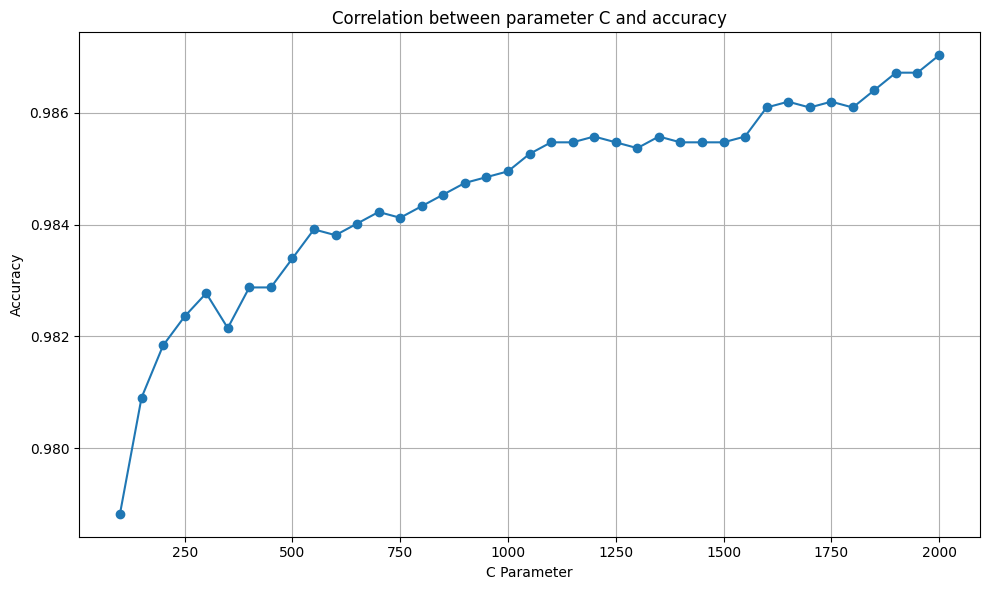

In [9]:
from sklearn.svm import SVC

accuracies = []
for c in range(100, 2050, 50):
    svm_model = SVC(C=c)
    svm_model.fit(X_train, y_train)
    accuracy = svm_model.score(X_test, y_test)
    accuracies.append(accuracy) # append to list
plt.figure(figsize=(10, 6))
plt.plot(range(100, 2050, 50), accuracies, marker='o', linestyle='-')

plt.title('Correlation between parameter C and accuracy')
plt.xlabel('C Parameter')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


## Making the Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
print(cm)

[[  63    0    0   15    0    0]
 [   0 3162   20   46    0    0]
 [   0   29 1620    0    0   15]
 [  13   21    0 1017    0    0]
 [   0    0    0    0  601   12]
 [   0    0   18    0   15 2969]]


## Visualization

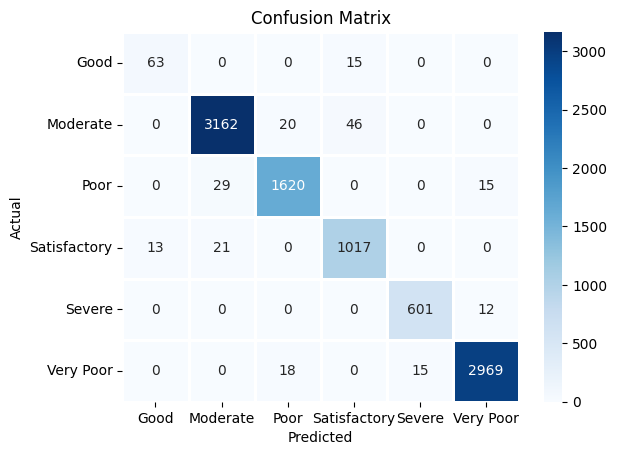

In [15]:

labels = ['Good', 'Moderate', 'Poor', 'Satisfactory', 'Severe','Very Poor']
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues', linewidth=1, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual', loc='center')
plt.xlabel('Predicted', loc='center')
plt.title('Confusion Matrix')
plt.show()

 ## Evaluate the model

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score,  roc_auc_score

def evaluateModel(X_test, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    y_prob = classifier.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    return {accuracy, auc}

### Visualization report on test df

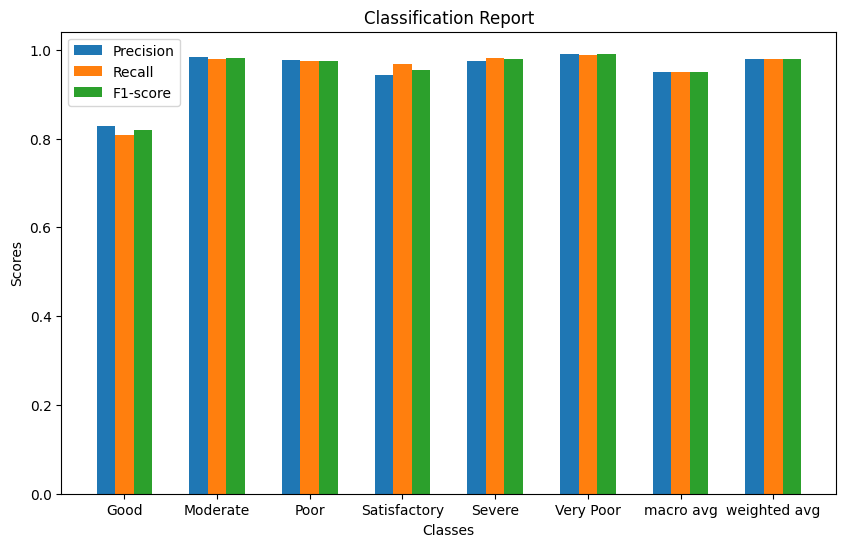

In [17]:
target_names = ['Good', 'Moderate', 'Poor', 'Satisfactory', 'Severe','Very Poor']  # Label
report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Lấy các giá trị từ classification report
precision = [report[key]['precision'] for key in report.keys() if key != 'accuracy']
recall = [report[key]['recall'] for key in report.keys() if key != 'accuracy']
f1_score = [report[key]['f1-score'] for key in report.keys() if key != 'accuracy']
classes = [key for key in report.keys() if key != 'accuracy']

# Vẽ biểu đồ bar cho precision, recall và f1-score
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(classes))

bar1 = ax.bar(index, precision, bar_width, label='Precision')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

plt.show()